# Label Correct

In [1]:
%cd ..

d:\autograde


## Testing

In [2]:
test_img = "IMG_2274_iter_0_1.10.jpg"

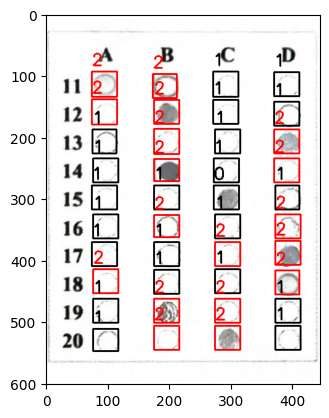

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
def draw_bboxes_yolo(image_path, label_path, output_path=None):
    """
    Draws bounding boxes on an image based on YOLOv8 format labels.

    Args:
        image_path: Path to the input image.
        label_path: Path to the YOLO label file.
        output_path: (Optional) Path to save the image with bounding boxes. 
                     If None, the image will be displayed.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    image_height, image_width = img.shape[:2]

    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return

    with open(label_path, "r") as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            # Convert normalized coordinates to pixel values
            x_center = int(x_center * image_width)
            y_center = int(y_center * image_height)
            width = int(width * image_width)
            height = int(height * image_height)

            # Calculate top-left corner coordinates
            x = int(x_center - width / 2)
            y = int(y_center - height / 2)

            if class_id == 2:
                color = (0, 0, 255)  # Red
            else:
                color = (0, 0, 0)  # Black (for any other class)

            # Draw the bounding box
            cv2.rectangle(img, (x, y), (x + width, y + height), color, 2)

            # Add class label text
            label = f"{int(class_id)}"
            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    if output_path:
        cv2.imwrite(output_path, img)
        print(f"Image with bounding boxes saved to {output_path}")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# --- Example Usage ---

# Paths
image_dir = "data/cropped_images"
label_dir = "data/std_num_bbox_labels"
test_img_name = "IMG_2274_iter_0_1.10.jpg"
test_label_name = test_img_name.replace(".jpg", ".txt") 

# Full paths to test image and label
test_img_path = os.path.join(image_dir, test_img_name)
test_label_path = os.path.join(label_dir, test_label_name)

# 1. Draw bounding boxes on the test image and display it:
draw_bboxes_yolo(test_img_path, test_label_path)

# 3. (Optional) Process all images in the directory and save them:
# output_dir = "data/images_with_bboxes"
# os.makedirs(output_dir, exist_ok=True) 

# for filename in os.listdir(image_dir):
#     if filename.endswith(".jpg"):
#         image_path = os.path.join(image_dir, filename)
#         label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
#         output_path = os.path.join(output_dir, filename)
#         draw_bboxes_yolo(image_path, label_path, output_path)

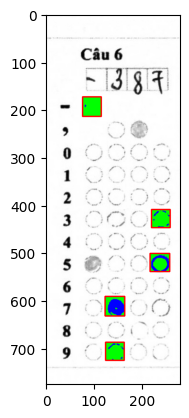

In [52]:
import cv2
import numpy as np
import os

def get_regions_with_label_two(image_path, label_path):
    # ... (This function remains the same as in the previous corrected version)
    """
    Extracts regions (bounding boxes) from an image that have the class label "2"
    according to a YOLO label file.

    Args:
        image_path: Path to the input image.
        label_path: Path to the YOLO label file.

    Returns:
        A list of tuples, where each tuple contains:
        - The bounding box coordinates (x1, y1, x2, y2)
        - The region of interest (the cropped image within the bounding box)
        - The original image
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return []

    image_height, image_width = img.shape[:2]

    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return []

    label_two_bbox_coords = []
    label_two_regions = []

    with open(label_path, "r") as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            if class_id == 2:  # Check if the class label is 2
                x_center_pixel = int(x_center * image_width)
                y_center_pixel = int(y_center * image_height)
                width_pixel = int(width * image_width)
                height_pixel = int(height * image_height)
                x1 = int(x_center_pixel - width_pixel / 2)
                y1 = int(y_center_pixel - height_pixel / 2)
                x2 = int(x_center_pixel + width_pixel / 2)
                y2 = int(y_center_pixel + height_pixel / 2)
                label_two_bbox_coords.append((x1, y1, x2, y2))

    for x1, y1, x2, y2 in label_two_bbox_coords:
        bbox_region = img[y1:y2, x1:x2]
        label_two_regions.append(((x1, y1, x2, y2), bbox_region, img))

    return label_two_regions

def kmeans_and_draw_on_regions(image, bbox_regions):
    """
    Performs K-means clustering (k=2) on the provided image regions,
    assigns colors based on distance to white, and draws the segmented results.

    Args:
        image: The original image (used for drawing).
        bbox_regions: A list of tuples, where each tuple contains:
                      - The bounding box coordinates (x1, y1, x2, y2)
                      - The region of interest (the cropped image)
                      - The original image (required to extract shape info)

    Returns:
        A copy of the image with segmented regions drawn.
    """
    img_copy = image.copy()

    for (x1, y1, x2, y2), bbox_region, original_img in bbox_regions:
        pixels = bbox_region.reshape(-1, 3)
        pixels = np.float32(pixels)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, centers = cv2.kmeans(pixels, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert centers to uint8
        centers = np.uint8(centers)

        # Calculate distances to white (255, 255, 255)
        white_color = np.array([255, 255, 255])
        distances_to_white = np.linalg.norm(centers - white_color, axis=1)

        # Determine cluster colors based on distance to white
        if distances_to_white[0] < distances_to_white[1]:
            # Center 0 is closer to white, assign green
            colors = np.array([[0, 255, 0], [255, 0, 0]])  # Green, Blue
        else:
            # Center 1 is closer to white, assign green
            colors = np.array([[255, 0, 0], [0, 255, 0]])  # Blue, Green

        segmented_data = colors[labels.flatten()]
        segmented_image = segmented_data.reshape(bbox_region.shape)

        img_copy[y1:y2, x1:x2] = segmented_image
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return img_copy

def process_and_render_image(image_path, label_path, output_image_path=None):
    # ... (This function remains the same as in the previous corrected version)
    """
    Processes an image, performs K-means clustering on regions with label "2",
    and either displays or saves the final image with segmented regions.

    Args:
        image_path: Path to the input image.
        label_path: Path to the YOLO label file.
        output_image_path: (Optional) Path to save the processed image.
    """
    # 1. Get regions with label "2"
    label_two_regions = get_regions_with_label_two(image_path, label_path)

    if not label_two_regions:
        print("No regions with label '2' found. Exiting.")
        return

    # 2. Perform K-means and draw on regions
    original_img = label_two_regions[0][2]
    processed_image = kmeans_and_draw_on_regions(original_img, label_two_regions)

    # 3. Display or save the image
    if output_image_path:
        cv2.imwrite(output_image_path, processed_image)
        print(f"Image with K-means clustered regions saved to {output_image_path}")
    else:
        plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

# --- Example Usage ---

# Paths (update these)
image_dir = "data/cropped_images"
label_dir = "data/std_num_bbox_labels"
test_img_name = "IMG_2274_iter_104_3.05.jpg"
test_label_name = test_img_name.replace(".jpg", ".txt")

# Full paths to test image and label
test_img_path = os.path.join(image_dir, test_img_name)
test_label_path = os.path.join(label_dir, test_label_name)


# Process the image and render the result
process_and_render_image(test_img_path, test_label_path)

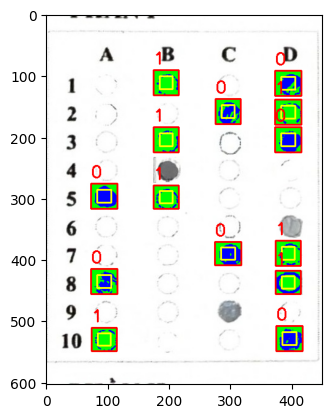

In [27]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def get_regions_with_label_two(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return []

    image_height, image_width = img.shape[:2]

    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return []

    label_two_bbox_coords = []
    label_two_regions = []

    with open(label_path, "r") as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            if class_id == 2:  # Check if the class label is 2
                x_center_pixel = int(x_center * image_width)
                y_center_pixel = int(y_center * image_height)
                width_pixel = int(width * image_width)
                height_pixel = int(height * image_height)
                x1 = int(x_center_pixel - width_pixel / 2)
                y1 = int(y_center_pixel - height_pixel / 2)
                x2 = int(x_center_pixel + width_pixel / 2)
                y2 = int(y_center_pixel + height_pixel / 2)
                label_two_bbox_coords.append((x1, y1, x2, y2))

    for x1, y1, x2, y2 in label_two_bbox_coords:
        bbox_region = img[y1:y2, x1:x2]
        label_two_regions.append(((x1, y1, x2, y2), bbox_region, img))

    return label_two_regions

def kmeans_and_draw_on_regions(image, bbox_regions):
    """
    Performs K-means clustering (k=2) on the provided image regions,
    assigns colors based on cluster centers (darker = blue, lighter = green),
    and draws the segmented results.

    Args:
        image: The original image (used for drawing).
        bbox_regions: A list of tuples, where each tuple contains:
                      - The bounding box coordinates (x1, y1, x2, y2)
                      - The region of interest (the cropped image)
                      - The original image (required to extract shape info)

    Returns:
        A copy of the image with segmented regions drawn.
        Also returns a list of segmented regions.
    """
    img_copy = image.copy()
    segmented_regions_list = []  # Store the segmented regions

    for (x1, y1, x2, y2), bbox_region, original_img in bbox_regions:
        pixels = bbox_region.reshape(-1, 3)
        pixels = np.float32(pixels)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, centers = cv2.kmeans(pixels, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert centers to uint8
        centers = np.uint8(centers)

        # Determine colors based on darkness (average intensity)
        avg_intensity = np.mean(centers, axis=1)
        if avg_intensity[0] < avg_intensity[1]:
            # Center 0 is darker, assign blue
            colors = np.array([[255, 0, 0], [0, 255, 0]])  # Blue, Green
        else:
            # Center 1 is darker, assign blue
            colors = np.array([[0, 255, 0], [255, 0, 0]])  # Green, Blue

        segmented_data = colors[labels.flatten()]
        segmented_image = segmented_data.reshape(bbox_region.shape)

        # Update the segmented region in the original image
        img_copy[y1:y2, x1:x2] = segmented_image

        # Store the segmented region with its coordinates
        segmented_regions_list.append(((x1, y1, x2, y2), segmented_image, original_img))

        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return img_copy, segmented_regions_list

def label_regions_by_color_count(image, segmented_regions, bbox_threshold, center_threshold):
    """
    Labels segmented regions based on the count of exact blue pixels
    in two areas: the full bounding box and a smaller central region.

    Args:
        image: The image with segmented regions (colors assigned).
        segmented_regions: A list of tuples, where each tuple contains:
                           - The bounding box coordinates (x1, y1, x2, y2)
                           - The segmented region of interest
                           - The original image (not used in this function)
        bbox_threshold: The threshold for the blue pixel ratio in the full bounding box.
        center_threshold: The threshold for the blue pixel ratio in the central region.

    Returns:
        A copy of the image with labels drawn on each region.
    """
    labeled_image = image.copy()

    for i, ((x1, y1, x2, y2), segmented_region, _) in enumerate(segmented_regions):
        # 1. Full Bounding Box Analysis
        # Exact blue color (BGR)
        exact_blue = np.array([255, 0, 0])  # Exact blue in BGR

        # Count exact blue pixels
        bbox_blue_count = np.sum(np.all(segmented_region == exact_blue, axis=-1))

        bbox_total_pixels = segmented_region.shape[0] * segmented_region.shape[1]
        bbox_blue_ratio = bbox_blue_count / bbox_total_pixels if bbox_total_pixels > 0 else 0

        # 2. Central Region Analysis
        center_x1 = x1 + (x2 - x1) // 4
        center_y1 = y1 + (y2 - y1) // 4
        center_x2 = x2 - (x2 - x1) // 4
        center_y2 = y2 - (y2 - y1) // 4
        center_region = segmented_region[
            (y2 - y1) // 4: 3 * (y2 - y1) // 4, (x2 - x1) // 4: 3 * (x2 - x1) // 4
        ]

        # Count exact blue pixels in the center region
        center_blue_count = np.sum(np.all(center_region == exact_blue, axis=-1))

        center_total_pixels = center_region.shape[0] * center_region.shape[1]
        center_blue_ratio = center_blue_count / center_total_pixels if center_total_pixels > 0 else 0

        # 3. Labeling based on thresholds
        if bbox_blue_ratio > bbox_threshold and center_blue_ratio > center_threshold:
            label = "0"  # Filled (both ratios above thresholds)
        else:
            label = "1"  # Not filled

        # Draw label and bounding boxes
        cv2.putText(
            labeled_image,
            label,
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 0, 255),
            2,
        )
        cv2.rectangle(labeled_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red for full bbox
        cv2.rectangle(
            labeled_image,
            (center_x1, center_y1),
            (center_x2, center_y2),
            (0, 255, 255),
            2,
        )  # Yellow for center region

    return labeled_image

def process_and_render_image(image_path, label_path, bbox_threshold, center_threshold, output_image_path=None):
    """
    Processes an image, performs K-means clustering on regions with label "2",
    labels them based on cluster centers, and either displays or saves the final image.

    Args:
        image_path: Path to the input image.
        label_path: Path to the YOLO label file.
        bbox_threshold: The threshold for the darkness ratio in the full bounding box.
        center_threshold: The threshold for the darkness ratio in the central region.
        output_image_path: (Optional) Path to save the processed image.
    """
    label_two_regions = get_regions_with_label_two(image_path, label_path)

    if not label_two_regions:
        print("No regions with label '2' found. Exiting.")
        return

    original_img = label_two_regions[0][2]

    segmented_image, segmented_regions = kmeans_and_draw_on_regions(
        original_img, label_two_regions
    )

    # Use the segmented_regions returned by kmeans_and_draw_on_regions
    labeled_image = label_regions_by_color_count(
        segmented_image, segmented_regions, bbox_threshold, center_threshold
    )

    plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))

# --- Example Usage ---

# Paths (update these)
image_dir = "data/cropped_images"
label_dir = "data/std_num_bbox_labels"
test_img_name = "IMG_2274_iter_110_1.00.jpg"
test_label_name = test_img_name.replace(".jpg", ".txt")

# Full paths to test image and label
test_img_path = os.path.join(image_dir, test_img_name)
test_label_path = os.path.join(label_dir, test_label_name)


# Thresholds
bbox_threshold = 0.3  # Example threshold for the full bounding box
center_threshold = 0.5  # Example threshold for the center region

# Process the image and render the result
process_and_render_image(
    test_img_path, test_label_path, bbox_threshold, center_threshold
)

## Process

In [56]:
import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

def get_regions_with_label_two(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return []

    image_height, image_width = img.shape[:2]

    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return []

    label_two_bbox_coords = []
    label_two_regions = []

    with open(label_path, "r") as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            if class_id == 2:  # Check if the class label is 2
                x_center_pixel = int(x_center * image_width)
                y_center_pixel = int(y_center * image_height)
                width_pixel = int(width * image_width)
                height_pixel = int(height * image_height)
                x1 = int(x_center_pixel - width_pixel / 2)
                y1 = int(y_center_pixel - height_pixel / 2)
                x2 = int(x_center_pixel + width_pixel / 2)
                y2 = int(y_center_pixel + height_pixel / 2)
                label_two_bbox_coords.append((x1, y1, x2, y2))

    for x1, y1, x2, y2 in label_two_bbox_coords:
        bbox_region = img[y1:y2, x1:x2]
        label_two_regions.append(((x1, y1, x2, y2), bbox_region, img))

    return label_two_regions

def kmeans_segmentation(bbox_regions):
    """
    Performs K-means clustering (k=2) on the provided image regions.

    Args:
        bbox_regions: A list of tuples, where each tuple contains:
                      - The bounding box coordinates (x1, y1, x2, y2)
                      - The region of interest (the cropped image)
                      - The original image (required to extract shape info)

    Returns:
        A list of segmented regions.
    """
    segmented_regions_list = []

    for (x1, y1, x2, y2), bbox_region, original_img in bbox_regions:
        pixels = bbox_region.reshape(-1, 3)
        pixels = np.float32(pixels)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, centers = cv2.kmeans(pixels, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert centers to uint8
        centers = np.uint8(centers)

        # Determine colors based on darkness (average intensity)
        avg_intensity = np.mean(centers, axis=1)
        if avg_intensity[0] < avg_intensity[1]:
            # Center 0 is darker, assign blue
            colors = np.array([[255, 0, 0], [0, 255, 0]])  # Blue, Green
        else:
            # Center 1 is darker, assign blue
            colors = np.array([[0, 255, 0], [255, 0, 0]])  # Green, Blue

        segmented_data = colors[labels.flatten()]
        segmented_image = segmented_data.reshape(bbox_region.shape)

        segmented_regions_list.append(((x1, y1, x2, y2), segmented_image, original_img))

    return segmented_regions_list

def label_regions_by_color_count(segmented_regions, bbox_threshold, center_threshold):
    """
    Labels segmented regions based on the count of exact blue pixels
    in two areas: the full bounding box and a smaller central region.

    Args:
        segmented_regions: A list of tuples, where each tuple contains:
                           - The bounding box coordinates (x1, y1, x2, y2)
                           - The segmented region of interest
                           - The original image (not used in this function)
        bbox_threshold: The threshold for the blue pixel ratio in the full bounding box.
        center_threshold: The threshold for the blue pixel ratio in the central region.

    Returns:
        A list of labels (0 or 1) for each region.
    """
    labels = []

    for i, ((x1, y1, x2, y2), segmented_region, _) in enumerate(segmented_regions):
        # 1. Full Bounding Box Analysis
        exact_blue = np.array([255, 0, 0])  # Exact blue in BGR
        bbox_blue_count = np.sum(np.all(segmented_region == exact_blue, axis=-1))
        bbox_total_pixels = segmented_region.shape[0] * segmented_region.shape[1]
        bbox_blue_ratio = bbox_blue_count / bbox_total_pixels if bbox_total_pixels > 0 else 0

        # 2. Central Region Analysis
        center_region = segmented_region[
            (y2 - y1) // 4: 3 * (y2 - y1) // 4, (x2 - x1) // 4: 3 * (x2 - x1) // 4
        ]
        center_blue_count = np.sum(np.all(center_region == exact_blue, axis=-1))
        center_total_pixels = center_region.shape[0] * center_region.shape[1]
        center_blue_ratio = center_blue_count / center_total_pixels if center_total_pixels > 0 else 0

        # 3. Labeling based on thresholds
        if bbox_blue_ratio > bbox_threshold and center_blue_ratio > center_threshold:
            label = 0  # Filled
        else:
            label = 1  # Not filled
        labels.append(label)

    return labels

def process_image_and_update_labels(image_path, label_path, new_label_path, bbox_threshold, center_threshold):
    """
    Processes an image, updates the YOLO label file based on the algorithm,
    and saves the new label file.

    Args:
        image_path: Path to the input image.
        label_path: Path to the original YOLO label file.
        new_label_path: Path to save the updated YOLO label file.
        bbox_threshold: Threshold for the blue pixel ratio in the full bounding box.
        center_threshold: Threshold for the blue pixel ratio in the central region.
    """
    label_two_regions = get_regions_with_label_two(image_path, label_path)

    if not label_two_regions:
        with open(label_path, 'r') as f_in, open(new_label_path, 'w') as f_out:
            f_out.write(f_in.read())
        return

    segmented_regions = kmeans_segmentation(label_two_regions)
    new_labels = label_regions_by_color_count(
        segmented_regions, bbox_threshold, center_threshold
    )

    # Update the label file
    label_two_count = 0
    with open(label_path, "r") as f_in, open(new_label_path, "w") as f_out:
        for line in f_in:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            if class_id == 2:
                new_label = new_labels[label_two_count]
                f_out.write(
                    f"{new_label} {x_center} {y_center} {width} {height}\n"
                )
                label_two_count += 1
            else:
                f_out.write(line)

def process_multiple_files(image_dir, label_dir, new_label_dir, csv_path, new_csv_path, bbox_threshold, center_threshold):
    """
    Processes multiple image and label files, updates labels, and saves a new CSV file.

    Args:
        image_dir: Directory containing the images.
        label_dir: Directory containing the original YOLO label files.
        new_label_dir: Directory to save the updated YOLO label files.
        csv_path: Path to the original CSV file.
        new_csv_path: Path to save the updated CSV file.
        bbox_threshold: Threshold for the blue pixel ratio in the full bounding box.
        center_threshold: Threshold for the blue pixel ratio in the central region.
    """
    df = pd.read_csv(csv_path)

    if not os.path.exists(new_label_dir):
        os.makedirs(new_label_dir)

    for index, row in tqdm(df.iterrows()):
        image_name = row['image_name']
        label_name = row['label_name']
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, label_name)
        new_label_path = os.path.join(new_label_dir, label_name)

        process_image_and_update_labels(
            image_path, label_path, new_label_path, bbox_threshold, center_threshold
        )

        # Count the number of label "2" that changed to 0
        num_label_2_changed = 0
        if os.path.exists(label_path) and os.path.exists(new_label_path):
            with open(label_path, "r") as f_old, open(new_label_path, "r") as f_new:
                new_labels = [line.strip().split()[0] for line in f_new]
                # count the number of 2 in new labels
                num_label_2_changed = new_labels.count("2")
        
        df.loc[index, 'number_label'] = len(new_labels) #Update number label
        df.loc[index, 'num_class_id_2'] = num_label_2_changed #Update number of changed labels

    df.to_csv(new_csv_path, index=False)

# --- Example Usage ---

# Paths (update these)
image_dir = "data/cropped_images"
label_dir = "data/std_num_bbox_labels"
new_label_dir = "data/std_labels"
csv_path = "data/std_num_bbox_data.csv"  # Replace with your CSV file name
new_csv_path = "data/std_labels_data.csv"

# Thresholds
bbox_threshold = 0.3
center_threshold = 0.5

# Process multiple files
process_multiple_files(
    image_dir,
    label_dir,
    new_label_dir,
    csv_path,
    new_csv_path,
    bbox_threshold,
    center_threshold,
)

83200it [1:06:44, 20.78it/s]
